In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import itertools

# SINDy - Sparse Identification of Nonlinear Dynamics -

次式の力学系について考える．
$$
  \frac{d x}{dt} = f(x) 
$$

時系列データ $X=[x(t_1),x(t_2),\ldots,x(t_m)]^T$ に対して，

その時間微分値 $\dot X=[\dot  x(t_1),\dot x(t_2),\ldots,\dot x(t_m)]^T$を考える．

$X$に任意の関数ライブラリ $[f_1,f_2,\ldots,f_p]$ を作用させた行列

$$
  \Theta (X) = [f_1(X),f_2(X),\ldots,f_p(X)]
$$
とする．

力学系がこの関数ライブラリ中の関数の線型結合によって表現できるならば，
$$
  \dot X = \Theta (X) \Xi
$$
ここで，$\Xi$は係数行列である．

$\xi_k$を$\Xi$の列ベクトルとして，例えば，次の最適化問題を解けばよい

$$
\xi_k = \mathrm{argmin}_{\xi'_k}\|\dot{X}_k-\Theta(X)\xi_k'\|_2+\lambda\|\xi_k'\|
$$
ここで，第二項は$\ell_1$正則化項である

例として，
$$
  \frac{d x}{dt}=-1+0.1x^2+\sin(x)
$$
というシステムを同定することを考えてみよう．

関数ライブラリは$f(x)=1,x,x^2,x^3,\sin(x),\cos(x)$を用いる

num sample =  (100,)
lasso iteration =  2
[-0.9999998   0.          0.09999999  0.          0.99999999  0.        ]


/var/folders/lh/h6v5t2d12gn0yc141bnlsd9r0000gn/T/ipykernel_68745/1987009536.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xi1,*_ = np.linalg.lstsq(theta,dx)


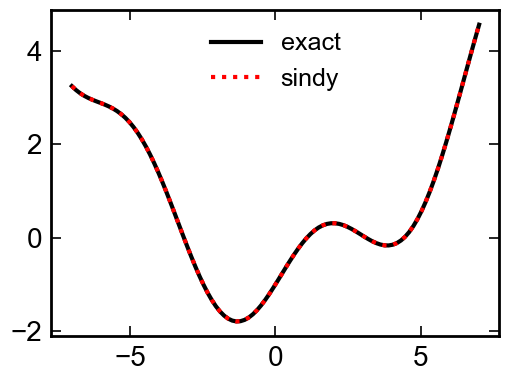

In [2]:

def ode(x):
  return -1.0 + 0.1*x**2 + np.sin(x)

def make_theta(x,fs):
  return np.array([f(x) for f in fs]).T

def sindy_stls(theta,dx,lam):
  ## sequential thresholded least-squared (STLS)
  xi,*_ = np.linalg.lstsq(theta,dx)
  for _ in range(10):
    small_inds = (np.abs(xi) < lam) # thredholded
    xi[small_inds] = 0.0
    big_inds = (small_inds == False)
    xi[big_inds],*_ = np.linalg.lstsq(theta[:,big_inds],dx)
  return xi

def sindy_lasso(theta,dx,lam):
  n = len(theta.T)
  xi0,*_ = np.linalg.lstsq(theta,dx)
  def loss(xi):
    return ( 1.0/(2*n)*np.power(dx-theta@xi,2).sum() \
      + lam * (np.abs(xi)).sum() )
  res = minimize(loss,xi0,method="Nelder-Mead",options=dict(maxiter=50))
  res = minimize(loss,res.x,method="BFGS",)
  # if not res.success: 
  #   print("[warn] cannot be minimized in lasso") 
  res.x[np.abs(res.x)<lam] = 0.0
  return res.x

def sindy_adaptivelasso(theta,dx,lam,delta=1.):
  n = len(theta.T)
  xi0 = np.ones(n)
  xi1,*_ = np.linalg.lstsq(theta,dx)
  w = np.ones(n)
  cnt = 0
  err = np.abs(xi1 - xi0)
  while cnt < 100 and err.max() > 1e-2*lam:
    err = np.abs(xi1 - xi0)
    xi0 = xi1.copy()
    theta1 = theta/w[np.newaxis,:]
    def loss(xi):
      return np.log( 1.0/(2*n)*np.power(dx-theta1@xi,2).sum() \
        + lam * (w * np.abs(xi)).sum() )
    res = minimize(loss,xi0,method="Nelder-Mead",options=dict(maxiter=50))
    res = minimize(loss,res.x,method="BFGS",)
    # if not res.success: 
    #   print("[warn] cannot be minimized in lasso") 
      # break
    xi1 = res.x/w
    w = 1.0/(np.abs(xi1)**(delta)+1e-30)
    cnt += 1
  print("lasso iteration = ",cnt)
  xi1[np.abs(xi1) < lam] = 0.0  
  return xi1

def main():
  # make data
  x = np.linspace(-7.0,7.0,100)
  print("num sample = ",x.shape)
  dx = ode(x)
  # build library
  fs = [
    *[lambda x,n=i: np.power(x,n) for i in range(4)],
    np.sin,
    np.cos,
    ]
  theta = make_theta(x,fs)
  # identify dynamics
  xi = sindy_adaptivelasso(theta,dx,1e-8,1e-1)
  print(xi)
  dx_identified = make_theta(x,fs)@xi

  plt.plot(x,dx,"k-",label="exact")
  plt.plot(x,dx_identified,"r:",label="sindy")
  plt.legend()

main()

一歩進んだ系として，Lorentz systemを考える．つまり，

$$
  \begin{align}
  \dot x &= \sigma(y-x) & \\
  \dot y &= x(\rho-z)-y & \\
  \dot z &= xy-\beta z  & 
  \end{align}
$$
パラメータは$\sigma=10,\ \rho=28\ \beta=8/3$.


x shape =  (10000, 3)
dx shape =  (10000, 3)
funclib nums =  8
theta shape =  (10000, 8)


/var/folders/lh/h6v5t2d12gn0yc141bnlsd9r0000gn/T/ipykernel_68745/606544826.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xi1[:,k],*_ = np.linalg.lstsq(theta,dx[:,k])


lasso iteration =  11
Xi =  [[ 0.          0.          0.        ]
 [ 0.          0.         -2.66666638]
 [ 9.99999261 -0.99982866  0.        ]
 [ 0.          0.          0.        ]
 [-9.99999158 27.99973245  0.        ]
 [ 0.         -0.99999259  0.        ]
 [ 0.          0.          0.99999996]
 [ 0.          0.          0.        ]]


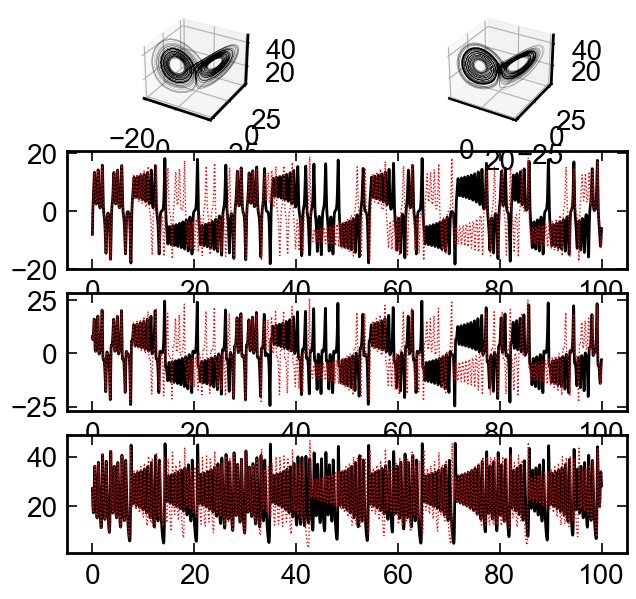

In [5]:

def ode(t,x):
  return lorentz(*x)

def lorentz(x,y,z,sigma=10.,rho=28.,beta=8./3.):
  dx = sigma * (y - x)
  dy = x * (rho-z) - y
  dz = x * y - beta * z
  return np.array([dx,dy,dz])

def make_theta(x,fs):
  return np.array([[f(xx) for xx in x] for f in fs]).T

def sindy_stls(theta,dx,lam):
  ## sequential thresholded least-squared (STLS)
  n,m = len(dx.T),len(theta.T)
  xi = np.zeros([m,n])
  for k in range(n):
    xi[:,k],*_ = np.linalg.lstsq(theta,dx[:,k])
  for _ in range(10):
    small_inds = (np.abs(xi) < lam) # thredholded
    xi[small_inds] = 0.0
    for k in range(n):
      big_inds = (small_inds[:,k] == False)
      xi[big_inds,k],*_ = np.linalg.lstsq(theta[:,big_inds],dx[:,k])
  return xi

def sindy_lasso(theta,dx,lam):
  n,m = len(dx.T),len(theta.T)
  xi0 = np.zeros([m,n])
  for k in range(n):
    def loss(xi):
      return ( 1.0/(2*len(dx))*np.power(dx[:,k]-theta@xi,2).sum() \
        + lam * (np.abs(xi)).sum() )
    res = minimize(loss,xi0[:,k],method="Nelder-Mead",)
    if not res.success: 
      print("[warn] cannot be minimized in lasso",res) 
    res.x[np.abs(res.x)<lam] = 0.0
    xi0[:,k] = res.x
  return xi0

def sindy_adaptivelasso(theta,dx,lam,delta=1.):
  n,m = len(dx.T),len(theta.T)
  xi0 = np.ones([m,n])
  xi1 = np.ones([m,n])
  for k in range(n):
    xi1[:,k],*_ = np.linalg.lstsq(theta,dx[:,k])
  w = np.ones([m,n])
  cnt = 0
  err = np.abs(xi1 - xi0)
  while cnt < 100 and err.max() > lam*1e-2:
    err = np.abs(xi1 - xi0)
    xi0 = xi1.copy()
    for k in range(n):
      theta1 = theta/w[:,k][np.newaxis,:]
      def loss(xi):
        return ( 1.0/(2*len(dx))*np.power(dx[:,k]-theta1@xi,2).sum() \
          + lam * (w[:,k] * np.abs(xi)).sum() )
      res = minimize(loss,xi0[:,k],method="Nelder-Mead",options=dict(maxiter=50))
      res = minimize(loss,res.x,method="BFGS",)
      # if not res.success: 
      #   print("[warn] cannot be minimized in lasso",res) 
      #   break
      xi1[:,k] = res.x/w[:,k]
      w[:,k] = 1.0/(np.abs(xi1[:,k])**(delta)+1e-30)
    cnt += 1
  print("lasso iteration = ",cnt)
  xi1[np.abs(xi1) < lam] = 0.0  
  return xi1


def main():
  fig = plt.figure(figsize=(8,8))

  # make data
  x0 = np.array([-8.0,8.0,27.0])
  t_span = (0.0,100.0)
  t_eval = np.linspace(*t_span,10000)
  sol = solve_ivp(ode,t_span,x0,rtol=1e-12,atol=1e-12,
    t_eval=t_eval,
  )
  t = sol.t
  x = sol.y.T
  dx = np.array([ lorentz(*xx) for xx in x])

  print("x shape = ",x.shape)
  print("dx shape = ",dx.shape)

  ax = fig.add_subplot(4,2,1,projection="3d")
  ax.plot(x[:,0],x[:,1],x[:,2],lw=0.1,
    # c=(sol.t/sol.t[-1]),marker="_",cmap=plt.get_cmap("plasma"),label="exact"
    )
  ax2 = fig.add_subplot(4,1,2)
  ax2.plot(t,x[:,0],"k-",lw=2)
  ax3 = fig.add_subplot(4,1,3)
  ax3.plot(t,x[:,1],"k-",lw=2)
  ax4 = fig.add_subplot(4,1,4)
  ax4.plot(t,x[:,2],"k-",lw=2)

  # build library
  itr = itertools.product(np.arange(2),repeat=3)
  # itr2 = itertools.product(np.arange(len(x0)),repeat=3); for i in itr2: print(i)
  fs = [
    *[lambda x,n=i: np.power(x[0],n[0])*np.power(x[1],n[1])*np.power(x[2],n[2]) for i in itr],
    ]
  theta = make_theta(x,fs)
  print("funclib nums = ",len(fs))
  print("theta shape = ",theta.shape)

  # identify dynamics
  xi = sindy_adaptivelasso(theta,dx,1e-4,0.1)
  print("Xi = ",xi)

  ode_identified = lambda t,x: (make_theta([x],fs)@xi)[0]

  t_span = (0.0,100.0)
  t_eval = np.linspace(*t_span,10000)
  sol_id = solve_ivp(ode_identified,t_span,x0,rtol=1e-12,atol=1e-12,
    t_eval=t_eval,
  )
  t = sol.t
  x = sol_id.y.T
  ax = fig.add_subplot(4,2,2,projection="3d")
  ax.plot(x[:,0],x[:,1],x[:,2],lw=0.1,
    # c=(sol.t/sol.t[-1]),marker="_",cmap=plt.get_cmap("plasma"),label="sindy"
    )
  ax2.plot(t,x[:,0],"r:",lw=1)
  ax3.plot(t,x[:,1],"r:",lw=1)
  ax4.plot(t,x[:,2],"r:",lw=1)

main()